<a href="https://colab.research.google.com/github/sanu1230/kaggel-competition/blob/master/kaggle_Titanic_Data_Compete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#kaggle - Titanic_Data_Compete

##Motive: 
To build models that can predict the survivers and non-survivers based on the each individual information provided

## Attributes:
- survival - Survival (0 = No; 1 = Yes)
- Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
- name - Name
- sex - Sex
- age - Age
- sibsp - Number of Siblings/Spouses Aboard
- parch - Number of Parents/Children Aboard
- ticket - Ticket Number
- fare - Passenger Fare
- cabin - Cabin
- embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [1]:
!pip -q install pandas_profiling==2.5.0

# Restart Runtime after running above cell 

In [1]:
!pip freeze | grep pandas

pandas==0.25.3
pandas-datareader==0.8.1
pandas-gbq==0.11.0
pandas-profiling==2.5.0
sklearn-pandas==1.8.0


In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import dask.dataframe as dd
import pandas_profiling
from IPython.display import HTML, display, IFrame


In [3]:
# Installing necessary packages
!pip -q install imgaug==0.2.5
!pip -q install shap
!pip -q install lime
!pip -q install eli5

#Loading Data

In [67]:
# loading data from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Loading train and test data 

train = pd.read_csv('/content/drive/My Drive/titanic/train.csv', index_col='PassengerId')
X_test = pd.read_csv('/content/drive/My Drive/titanic/test.csv', index_col='PassengerId')
y_test = pd.read_csv('/content/drive/My Drive/titanic/gender_submission.csv', index_col='PassengerId')

In [69]:
test = pd.concat([X_test, y_test], axis=1)
test.isna().sum()
test.shape

(418, 11)

In [70]:
test.head()

Pclass  ... Survived
PassengerId          ...         
892               3  ...        0
893               3  ...        1
894               2  ...        0
895               3  ...        0
896               3  ...        1

[5 rows x 11 columns]

In [71]:
train.head()

Survived  Pclass  ... Cabin Embarked
PassengerId                    ...               
1                   0       3  ...   NaN        S
2                   1       1  ...   C85        C
3                   1       3  ...   NaN        S
4                   1       1  ...  C123        S
5                   0       3  ...   NaN        S

[5 rows x 11 columns]

In [72]:
print(train.shape)
print(test.shape)

(891, 11)
(418, 11)


# Exploratory Data Analyisis

## Understanding Data

In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
Survived    418 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [75]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [76]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
Survived      0
dtype: int64

**Observation:** We see missing values in feature Age, Cabin & Embarked in bioth train and test data 

In [77]:
# Data Summary
train.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [78]:
test.describe()

Pclass         Age       SibSp       Parch        Fare    Survived
count  418.000000  332.000000  418.000000  418.000000  417.000000  418.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188    0.363636
std      0.841838   14.181209    0.896760    0.981429   55.907576    0.481622
min      1.000000    0.170000    0.000000    0.000000    0.000000    0.000000
25%      1.000000   21.000000    0.000000    0.000000    7.895800    0.000000
50%      3.000000   27.000000    0.000000    0.000000   14.454200    0.000000
75%      3.000000   39.000000    1.000000    0.000000   31.500000    1.000000
max      3.000000   76.000000    8.000000    9.000000  512.329200    1.000000

## Pandas Profiling

In [79]:
import pandas_profiling

report = pandas_profiling.ProfileReport(train)
report.to_file('Titanic_train.html')

In [80]:
display(HTML(open('/content/Titanic_train.html').read()))

**Observation:**
- 'Name' and 'Ticket' has high cardinality hence can be dropped.
- 'Cabin' has many missing values, replacing missing values with any other will give unrealistic data, hence dropping it.
- 'Age' has 177 missing values, hence replacing it with mean/avg.
- 'SibSp' & 'Parch' has 608 zeros, which means that many passengers were traveling without their parents/child/siblings, hence zeros are valid value.
- 'Fare' has 15 values as zeros, possible fare given to special passangers. However, it also has an outlier of max fare more them $500..

## Dropping insignificant features 

In [81]:
#These features has no significance hence dropping them

del train['Name']
del train['Ticket']
del train['Cabin']

del test['Name']
del test['Ticket']
del test['Cabin']

In [82]:
#@title Save Copy 1
train1 = train.copy()

## Removing Outliers

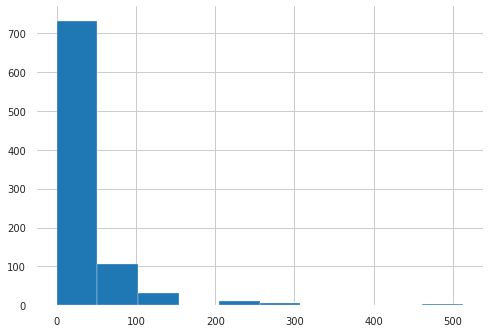

In [83]:
train['Fare'].hist()

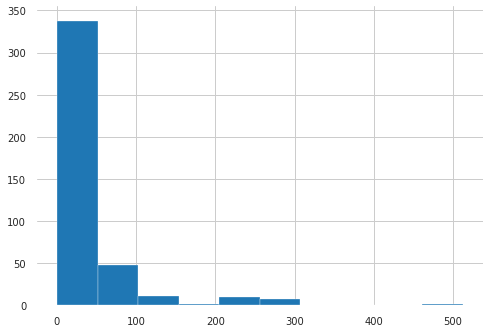

In [84]:
test['Fare'].hist()

In [85]:
# we see outlier of $500 as fare price
# However we will only remove the outlier from the train data as we need to train our model

In [86]:
# lets remove the Outlier in Fare column
train= train[train['Fare'] < 400]


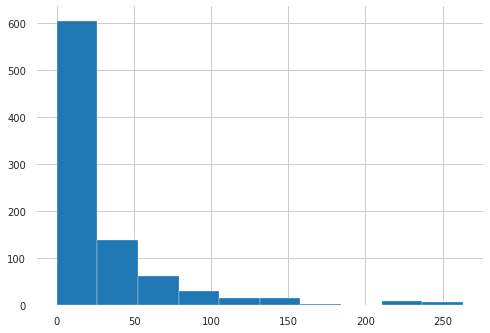

In [87]:
#Lets Checks Outliers
train['Fare'].hist()

**Observation:**
- No more outliers in the column Fare

In [88]:
print(train.shape)
print(test.shape)

(888, 8)
(418, 8)


## Filling Missing Values

In [89]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [90]:
test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Survived     0
dtype: int64

In [91]:
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
# train['Fare'].fillna(train['Fare'].mean(), inplace=True)

test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

In [92]:
# Check if any NaN in both data
print('train isna:- \n', train.isna().sum())
print('')
print('test isna:- \n', test.isna().sum())

train isna:- 
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

test isna:- 
 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [93]:
#@title Save Copy 2
train2 = train.copy()

# Data Visualization

## Relation between Data

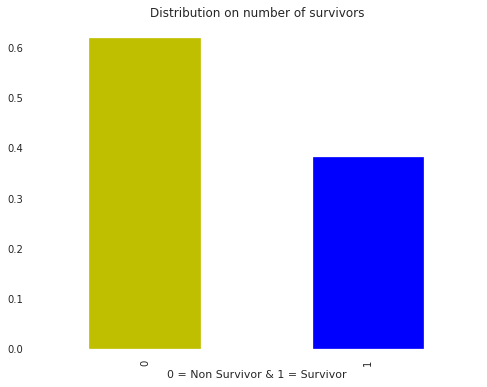

In [94]:
# Distribution of Survivors and non survivors

plt.figure(figsize=(8, 6))
train.Survived.value_counts(normalize=True).plot(kind='bar', color=['y', 'b'], 
                                                 title='Distribution on number of survivors')
plt.xlabel('0 = Non Survivor & 1 = Survivor')
plt.show()

**Observation:** - Almost 40% of passangers survived and 60% did not survive

## Distribution of survivors based on Pclass & Sex

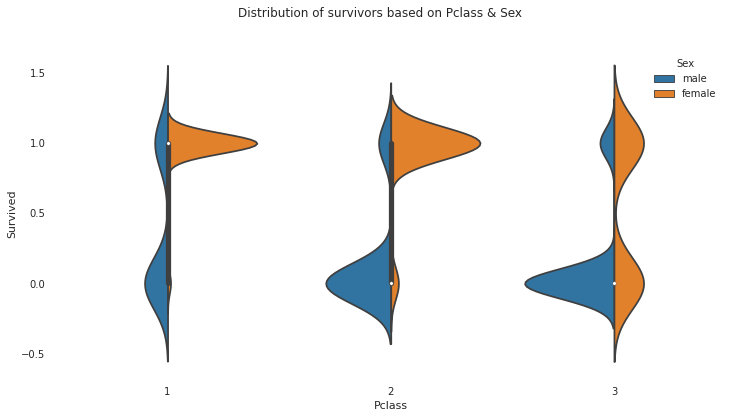

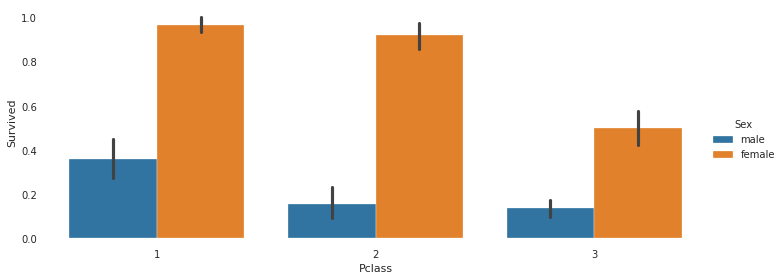

In [95]:
# Lets Analysis survivors based on Pclass and the preference given to them to survive

plt.figure(figsize=(12, 6))
plt.suptitle("Distribution of survivors based on Pclass & Sex")

sns.violinplot(data=train, x='Pclass', y='Survived', hue='Sex', split=True, cut=3)
sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', kind='bar', height=4, aspect=2.5)
plt.show()



**Observation:**
- More number of mens survived from Pclass 1st compared to other Pclass
- Womens from 1st and 2nd Pclass were give first preference to survive, compared to women in 3rd Pclass
- However this graph only shows about passanges who survived.

## Analyse Passanges (male/female) from diff Pclass who survived/not-survived

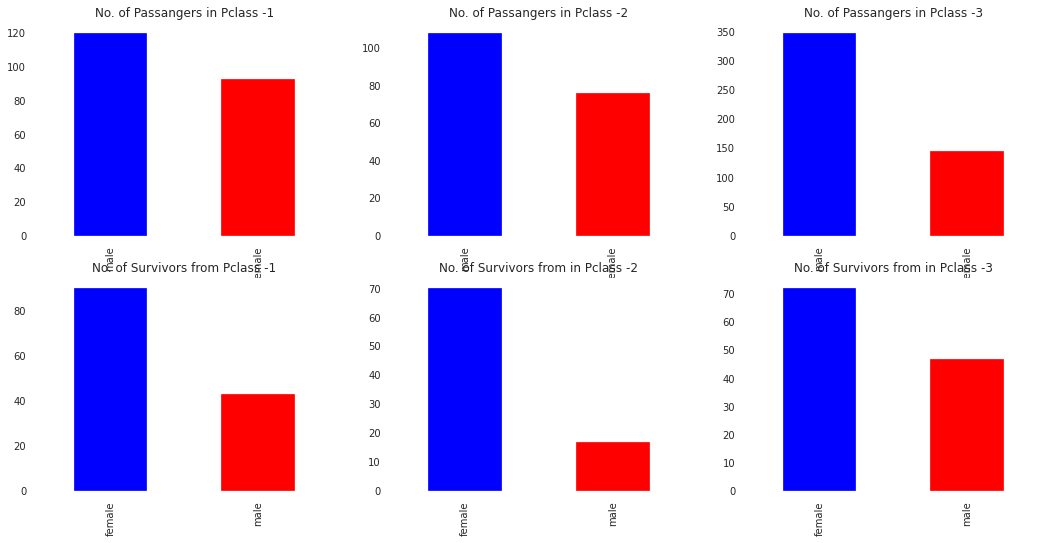

In [96]:
# Lets further analysis, how many passenger (male & female) were there in each Pclass and how many from each survived

plt.figure(figsize=(18, 18))

colors = {'male':'b', 'female':'r'}
color = train['Sex'].apply(lambda x: colors[x])

plt.subplot2grid((4, 3), (0, 0))
train.Sex[train.Pclass == 1].value_counts().plot(kind='bar', color=color)
plt.title('No. of Passangers in Pclass -1')

plt.subplot2grid((4, 3), (0, 1))
train.Sex[train.Pclass == 2].value_counts().plot(kind='bar', color=color)
plt.title('No. of Passangers in Pclass -2')

plt.subplot2grid((4, 3), (0, 2))
train.Sex[train.Pclass == 3].value_counts().plot(kind='bar', color=color)
plt.title('No. of Passangers in Pclass -3')

plt.subplot2grid((4, 3), (1, 0))
train.Sex[(train.Pclass == 1) & (train.Survived == 1)].value_counts().plot(kind='bar', color=color)
plt.title('No. of Survivors from Pclass -1')

plt.subplot2grid((4, 3), (1, 1))
train.Sex[(train.Pclass == 2)  & (train.Survived == 1)].value_counts().plot(kind='bar', color=color)
plt.title('No. of Survivors from in Pclass -2')

plt.subplot2grid((4, 3), (1, 2))
train.Sex[(train.Pclass == 3)  & (train.Survived == 1)].value_counts().plot(kind='bar', color=color)
plt.title('No. of Survivors from in Pclass -3')


plt.show()

**Observation:**
-  From Pclass -1, we see that from around 120 females - 90(+/-) females survived, and from around 90+ males - 35(+/-) males survived
-  From Pclass -2, we see that from around 110 females - 70(+/-) females survived, and from around 70 males - 15(+/-) males survived
-  From Pclass -3, we see that from around 350 females - 70(+/-) females survived, and from around 140 males - 45(+/-) males survived

In [97]:
train.shape

(888, 8)

## Age's that Survived

Text(0.5, 1.0, "Age's that Survived")

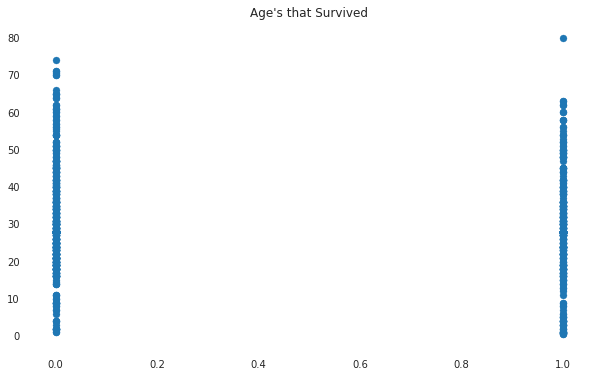

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(train.Survived, train.Age)
plt.title("Age's that Survived")


**Observation:** 
- The Ages for Survivor graph give a mixed relation on ages on survived and non-survived

## Pclass related to Age's

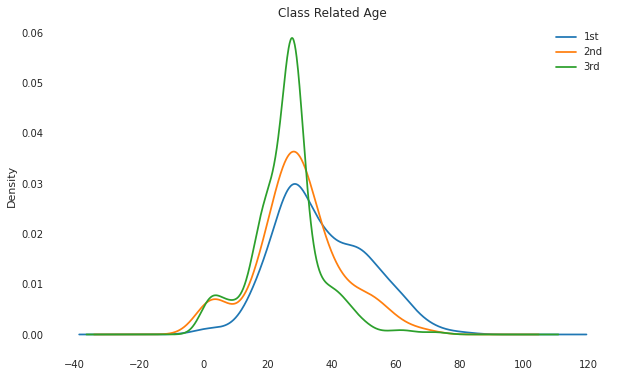

In [99]:
# Pclass related to Age

plt.figure(figsize=(10, 6))
for x in [1, 2, 3]:
  train.Age[train.Pclass == x].plot(kind='kde')
plt.title('Class Related Age')
plt.legend(('1st', '2nd', '3rd'))
plt.show()

**Observation:** 
- From the above graph we can see that, 2nd and 3rd Pclass has more of children aged between 1 to 20 yrs and less of aged people. And 1st Pclass has more aged passangers between 50 to 80 yrs.


## Graph of Survived, based on Sex

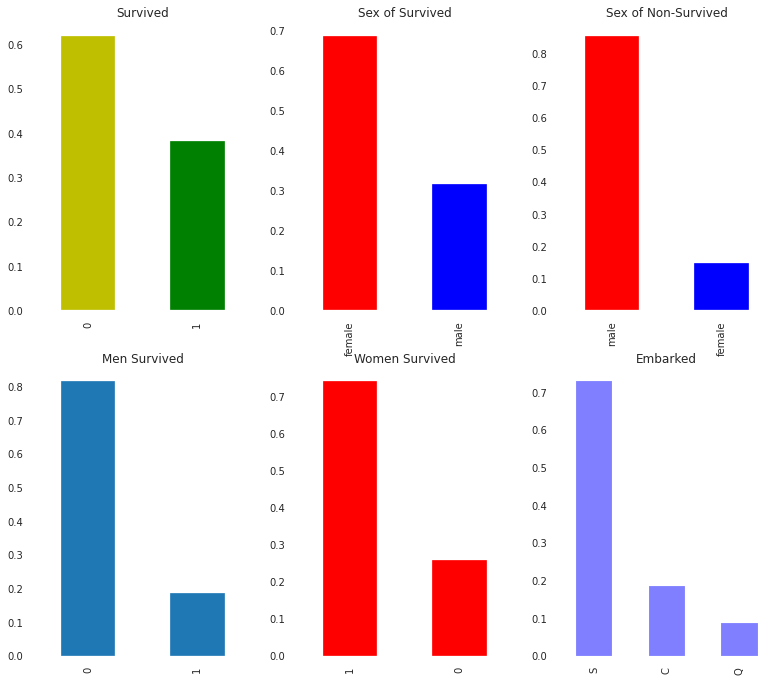

In [100]:
# Graph based on Survived, based on Sex

plt.figure(figsize=(18, 18))
plt.subplot2grid((3, 4), (0, 0))
train.Survived.value_counts(normalize=True).plot(kind='bar', color=['y', 'g'])
plt.title('Survived')

plt.subplot2grid((3, 4), (0, 1))
train.Sex[train.Survived == 1].value_counts(normalize=True).plot(kind='bar', color=['r', 'b'])
plt.title('Sex of Survived')

plt.subplot2grid((3, 4), (0, 2))
train.Sex[train.Survived == 0].value_counts(normalize=True).plot(kind='bar', color=['r', 'b'])
plt.title('Sex of Non-Survived')

plt.subplot2grid((3, 4), (1, 0))
train.Survived[train.Sex == 'male'].value_counts(normalize=True).plot(kind='bar')
plt.title('Men Survived')

plt.subplot2grid((3, 4), (1, 1))
train.Survived[train.Sex == 'female'].value_counts(normalize=True).plot(kind='bar', color='r')
plt.title('Women Survived')

plt.subplot2grid((3, 4), (1, 2))
train.Embarked.value_counts(normalize=True).plot(kind='bar', color='b', alpha=0.5)
plt.title('Embarked')



plt.show()

**Observation:**
- The above graphs show complete detail on number passenges based on Sex that survived and not-sutvived

## Distribution of Embarked based on Survivor and Pclass

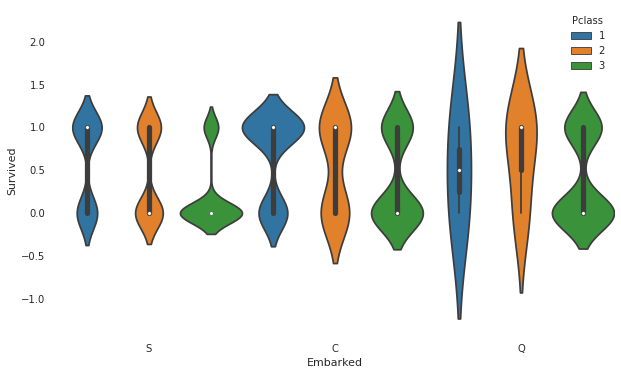

In [101]:
# Distribution of Embarked based on Survivor and Pclass
plt.figure(figsize=(10, 6))
sns.violinplot(x=train['Embarked'], y=train['Survived'], hue=train['Pclass'], width=1)
plt.show()

## Trend of Survivors

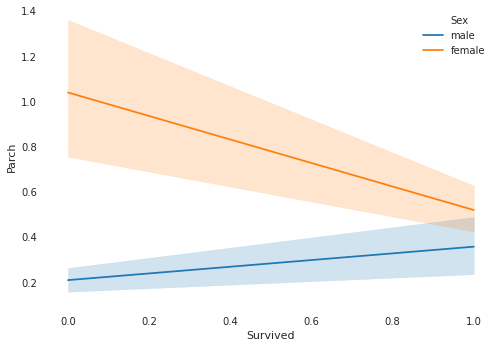

In [102]:
# Trend of Survivors based on Parch & Sex

sns.lineplot(x=train['Survived'], y=train['Parch'], hue=train['Sex'])

**Observation:**
The above graph shows that large number of Parent(female)&children Parch did not survive. While more number of male parents did survive compared to its ratio.

## Trend of Ages based on Parch & Sex

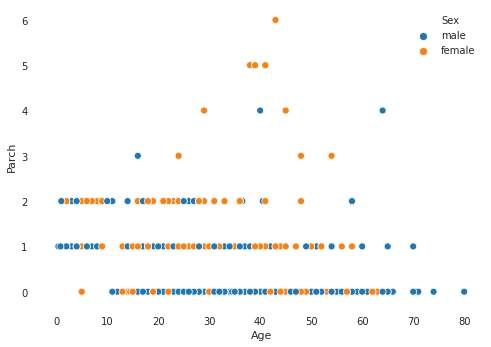

In [103]:
  # Trend of Age based on Parch & Sex

  sns.scatterplot(data=train, x='Age', y='Parch', hue='Sex')

**Observation:**
- Maximum Parents/couples had 0 to 2 children and very had more than 2 children

## Heatmap to see Correlation

In [104]:
train.corr()

Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.334068 -0.067081 -0.033395  0.082157  0.261742
Pclass   -0.334068  1.000000 -0.338998  0.080937  0.018212 -0.604960
Age      -0.067081 -0.338998  1.000000 -0.232732 -0.172623  0.098801
SibSp    -0.033395  0.080937 -0.232732  1.000000  0.415141  0.211816
Parch     0.082157  0.018212 -0.172623  0.415141  1.000000  0.263910
Fare      0.261742 -0.604960  0.098801  0.211816  0.263910  1.000000

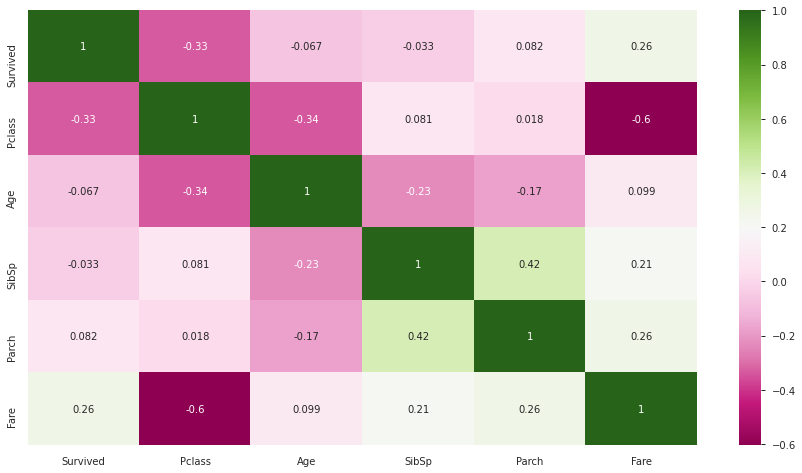

In [105]:
plt.figure(figsize=(15, 8))
sns.heatmap(train.corr(), annot=True, cmap='PiYG')

**Observation**
- There are no high correlation between any features which is more than 70% (considered threshold)



In [106]:
#@title Save Copy 3
train3 = train.copy()

# Feature Engineering

Lets Create some new Features

In [107]:
#@title Lets categorise family group 

train['family_size'] = train['SibSp']+train['Parch']+1 #The 1 is in-case if the passanger is not travaline with any sibling, spouse, parent or child then it will be counted as 1
test['family_size'] = test['SibSp']+test['Parch']+1

# Lets create family_group category

def family_group(size):
  a=''
  if (size <= 1):
    a='alone'
  elif (size <= 4):
    a='small'
  else:
    a='large'
  return a

# lets map the new feature to family_size
train['family_group'] = train.family_size.map(family_group)
test['family_group'] = test.family_size.map(family_group)
train.head()

Survived  Pclass     Sex  ...  Embarked  family_size  family_group
PassengerId                            ...                                     
1                   0       3    male  ...         S            2         small
2                   1       1  female  ...         C            2         small
3                   1       3  female  ...         S            1         alone
4                   1       1  female  ...         S            2         small
5                   0       3    male  ...         S            1         alone

[5 rows x 10 columns]

In [108]:
#@title Lets categorise Age group

def age_group(age):
  b=''
  if (age <= 1):
    b = 'infant'
  elif (age <= 4):
    b = 'toddler'
  elif (age <= 14):
    b = 'child'
  elif (age <= 20):
    b = 'teenager'
  elif (age <= 30):
    b = 'young'
  elif (age <= 45):
    b = 'adult'
  elif (age <= 60):
    b = 'middleage'
  else:
    b = 'old'
  return b

train['age_group']= train.Age.map(age_group)
test['age_group']= test.Age.map(age_group)
train.head()
  

Survived  Pclass     Sex  ...  family_size  family_group  age_group
PassengerId                            ...                                      
1                   0       3    male  ...            2         small      young
2                   1       1  female  ...            2         small      adult
3                   1       3  female  ...            1         alone      young
4                   1       1  female  ...            2         small      adult
5                   0       3    male  ...            1         alone      adult

[5 rows x 11 columns]

In [109]:
train.age_group.value_counts()

young        407
adult        199
teenager     102
middleage     81
child         37
toddler       26
old           22
infant        14
Name: age_group, dtype: int64

Now we can see that the maximum number pf passangers were in the age group of 30yr 

In [110]:
train.shape

(888, 11)

In [111]:
#@title Lets find Fare per person and categorise

# Fare per person
train['fare_per_person'] = train['Fare']/train['family_size']
test['fare_per_person'] = test['Fare']/test['family_size']

#Lets create some categories

def fare_group(fare):
  f =''
  if (fare <= 4):
    f = 'very_low'
  elif (fare <= 10):
    f = 'low'  
  elif (fare <= 20):
    f = 'mid'  
  elif (fare <= 45):
    f = 'high'  
  else:
    f = 'very_high'
  return f

train['fare_group'] = train.fare_per_person.map(fare_group)
test['fare_group'] = test.fare_per_person.map(fare_group)
train.head()

Survived  Pclass     Sex  ...  age_group  fare_per_person  fare_group
PassengerId                            ...                                        
1                   0       3    male  ...      young          3.62500    very_low
2                   1       1  female  ...      adult         35.64165        high
3                   1       3  female  ...      young          7.92500         low
4                   1       1  female  ...      adult         26.55000        high
5                   0       3    male  ...      adult          8.05000         low

[5 rows x 13 columns]

In [112]:
train.fare_group.value_counts()

low          471
high         154
mid          153
very_high     69
very_low      41
Name: fare_group, dtype: int64

This shows maximum passanges had fare less or equal to $4

In [113]:
#@title Converting 'Sex' to from oject to int
train['Sex'] = train.Sex.apply(lambda x: 0 if x == 'female' else 1)
test['Sex'] = test.Sex.apply(lambda x:0 if x== 'female' else 1)
test.head()

Pclass  Sex   Age  ...  age_group  fare_per_person  fare_group
PassengerId                     ...                                        
892               3    1  34.5  ...      adult         7.829200         low
893               3    0  47.0  ...  middleage         3.500000    very_low
894               2    1  62.0  ...        old         9.687500         low
895               3    1  27.0  ...      young         8.662500         low
896               3    0  22.0  ...      young         4.095833         low

[5 rows x 13 columns]

In [114]:
test.Embarked.unique()

array(['Q', 'S', 'C'], dtype=object)

In [115]:
#@title Converting Embarked to int with label encoding
dic = {'S': 1, 'C': 2, 'Q': 3}

train['embarked']= train['Embarked'].apply(lambda x: dic[x])
test['embarked']= test['Embarked'].apply(lambda x: dic[x])
del train['Embarked']
del test['Embarked']
train.head()
test.head()

Pclass  Sex   Age  ...  fare_per_person  fare_group  embarked
PassengerId                     ...                                       
892               3    1  34.5  ...         7.829200         low         3
893               3    0  47.0  ...         3.500000    very_low         1
894               2    1  62.0  ...         9.687500         low         3
895               3    1  27.0  ...         8.662500         low         1
896               3    0  22.0  ...         4.095833         low         1

[5 rows x 13 columns]

In [116]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# train['Embarked'] = le.fit_transform(train['Embarked'])
# test['Embarked'] = le.fit_transform(test['Embarked'])

# print(train.head())
# print(test.head())

In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888 entries, 1 to 891
Data columns (total 13 columns):
Survived           888 non-null int64
Pclass             888 non-null int64
Sex                888 non-null int64
Age                888 non-null float64
SibSp              888 non-null int64
Parch              888 non-null int64
Fare               888 non-null float64
family_size        888 non-null int64
family_group       888 non-null object
age_group          888 non-null object
fare_per_person    888 non-null float64
fare_group         888 non-null object
embarked           888 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 137.1+ KB


In [118]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 13 columns):
Pclass             418 non-null int64
Sex                418 non-null int64
Age                418 non-null float64
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null float64
Survived           418 non-null int64
family_size        418 non-null int64
family_group       418 non-null object
age_group          418 non-null object
fare_per_person    418 non-null float64
fare_group         418 non-null object
embarked           418 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 45.7+ KB


## Label Encoding all object datatype

In [119]:
# Label encoding categorical features that we just created (family_group, age_group & fare_group)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['family_group'] = le.fit_transform(train['family_group'])
test['family_group'] = le.fit_transform(test['family_group'])

train['age_group'] = le.fit_transform(train['age_group'])
test['age_group'] = le.fit_transform(test['age_group'])

train['fare_group'] = le.fit_transform(train['fare_group'])
test['fare_group'] = le.fit_transform(test['fare_group'])

train.head()
test.head()

Pclass  Sex   Age  ...  fare_per_person  fare_group  embarked
PassengerId                     ...                                       
892               3    1  34.5  ...         7.829200           1         3
893               3    0  47.0  ...         3.500000           4         1
894               2    1  62.0  ...         9.687500           1         3
895               3    1  27.0  ...         8.662500           1         1
896               3    0  22.0  ...         4.095833           1         1

[5 rows x 13 columns]

# Data Splitting and Normalizing

In [120]:
# Splitting Data in X and y for both train and test

X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

X_test = test.drop(['Survived'], axis=1)
y_test = test['Survived']


#Lets Use Sandardscaler to normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

# Scale and center the data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create a pandas DataFrame
X_train = pd.DataFrame(data=X_train_normalized, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(data=X_test_normalized, index=X_test.index, columns=X_test.columns)

X_train.head()


Pclass       Sex  ...  fare_group  embarked
PassengerId                      ...                      
1            0.873482  0.755929  ...    2.803052 -0.677841
2           -1.505120 -1.322876  ...   -1.329843  0.782662
3            0.873482 -1.322876  ...   -0.296619 -0.677841
4           -1.505120 -1.322876  ...   -1.329843 -0.677841
5            0.873482  0.755929  ...   -0.296619 -0.677841

[5 rows x 12 columns]

# Feature Importance

[0.08191678 0.27802345 0.173081   0.02005478 0.01996996 0.12418097
 0.02719538 0.03611106 0.0517713  0.12142087 0.03303246 0.03324199]


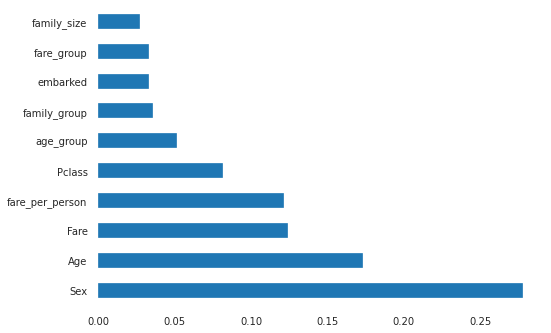

In [121]:
from sklearn.ensemble import ExtraTreesClassifier

model1 = ExtraTreesClassifier()
model1.fit(X_train, y_train)

print(model1.feature_importances_) #using inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances_train = pd.Series(model1.feature_importances_, index=X_train.columns)
feat_importances_train.nlargest(10).plot(kind='barh')
plt.show()


In [122]:
print('train', X_train.shape)
print('test', X_test.shape)

train (888, 12)
test (418, 12)


In [123]:
#@title Save Copy 4
train4 = train.copy()


# Model Building

In [124]:
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, recall_score


def model_train(model, name):
    model.fit(X_train, y_train)                                          # Fitting the model
    y_pred = model.predict(X_test)                                       # Making prediction from the trained model
    cm = confusion_matrix(y_test, y_pred)                               
    print("Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
    print(cm)
    print('-----------------------')
    print('-----------------------')
    cr = classification_report(y_test, y_pred)
    print(name +" Classification Report " +" Validation Data")           # Displaying the Classification Report
    print(cr)
    print('')
    print('------------------------')
    print('------------------------')
    print('')
    print('_________________________')
    print('')
    print(name +" AUC Score " +" Validation Data")
    auc = roc_auc_score(y_test, y_pred)       
    print("AUC Score " + str(auc))  
    print('_________________________')
    print('') 
    print('_________________________')
    print('')
    print(name +" Recall " +" Validation Data")
    rec = recall_score(y_test, y_pred)
    print("Recall "+ str(rec))
    print('_________________________')
    print('')                                           # Displaying the Recall score
    print('_________________________')
    print('')
    print(name + " Bias")                                                 # Calculating bias
    bias = y_pred - y_test.mean()
    print("Bias "+ str(bias.mean()))
    print('_________________________')
    print('')
    print('_________________________')
    print('')
    print(name + " Variance")                                             # Calculate Variance
    var = np.var([y_test, y_pred], axis=0)
    print("Variance " + str(var.mean()) )
    print('_________________________')
    return auc, rec, model



## Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

model_train(lr, "Logistic Regression")

Grid Search Confusion Matrix  Validation Data
[[250  16]
 [  8 144]]
-----------------------
-----------------------
Logistic Regression Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       266
           1       0.90      0.95      0.92       152

    accuracy                           0.94       418
   macro avg       0.93      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418


------------------------
------------------------

_________________________

Logistic Regression AUC Score  Validation Data
AUC Score 0.9436090225563909
_________________________

_________________________

Logistic Regression Recall  Validation Data
Recall 0.9473684210526315
_________________________

_________________________

Logistic Regression Bias
Bias 0.019138755980861205
_________________________

_________________________

Logistic Regression Variance
Variance 0.014354066985645933


(0.9436090225563909,
 0.9473684210526315,
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False))

## Decision Tree

In [126]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini',max_depth = 10, min_samples_leaf =3)

model_train(dt, "Decision Tree Classifier")

Grid Search Confusion Matrix  Validation Data
[[221  45]
 [ 41 111]]
-----------------------
-----------------------
Decision Tree Classifier Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       266
           1       0.71      0.73      0.72       152

    accuracy                           0.79       418
   macro avg       0.78      0.78      0.78       418
weighted avg       0.80      0.79      0.79       418


------------------------
------------------------

_________________________

Decision Tree Classifier AUC Score  Validation Data
AUC Score 0.7805451127819548
_________________________

_________________________

Decision Tree Classifier Recall  Validation Data
Recall 0.7302631578947368
_________________________

_________________________

Decision Tree Classifier Bias
Bias 0.009569377990430589
_________________________

_________________________

Decision Tree Classifier Variance
Varia

(0.7805451127819548,
 0.7302631578947368,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=10, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'))

## Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500, criterion='gini', max_depth = 250, min_samples_split=3, random_state=55)

model_train(rf, "Random Forest Classifier")

Grid Search Confusion Matrix  Validation Data
[[234  32]
 [ 36 116]]
-----------------------
-----------------------
Random Forest Classifier Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       266
           1       0.78      0.76      0.77       152

    accuracy                           0.84       418
   macro avg       0.83      0.82      0.82       418
weighted avg       0.84      0.84      0.84       418


------------------------
------------------------

_________________________

Random Forest Classifier AUC Score  Validation Data
AUC Score 0.8214285714285714
_________________________

_________________________

Random Forest Classifier Recall  Validation Data
Recall 0.7631578947368421
_________________________

_________________________

Random Forest Classifier Bias
Bias -0.00956937799043065
_________________________

_________________________

Random Forest Classifier Variance
Varia

(0.8214285714285714,
 0.7631578947368421,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=250, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=3,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=55, verbose=0,
                        warm_start=False))

## Grid SerachCV

In [128]:
from sklearn.model_selection import GridSearchCV

random_grid = {'n_estimators': range(5,50,5),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [10,20,30,40],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,2,4]
               }

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

rf_gs.fit(X_train, y_train)
y_pred = rf_gs.predict(X_test)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 1334 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  1.3min finished


In [129]:
rf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
print("Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Grid Search Validation Data
Grid Search Confusion Matrix  Validation Data
[[239  27]
 [ 32 120]]
-----------------------
Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.82      0.79      0.80       152

    accuracy                           0.86       418
   macro avg       0.85      0.84      0.85       418
weighted avg       0.86      0.86      0.86       418

------------------------
Grid Search AUC Score  Validation Data
AUC Score 0.8439849624060151
Grid Search Recall  Validation Data
Recall 0.7894736842105263
_________________________
Grid Search Bias
Bias -0.011961722488038309
Grid Search Variance
Variance 0.035287081339712915


## Randomized Grid Search

In [131]:
  from sklearn.model_selection import RandomizedSearchCV

  rf = RandomForestClassifier()

  rf_random = RandomizedSearchCV(rf, random_grid, cv = 3, n_jobs=-1, verbose=2)

  rf_random.fit(X_train, y_train)
  y_pred = rf_random.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


In [132]:
print("Randomized Grid Search Validation Data")
cm = confusion_matrix(y_test, y_pred)                               
print("Randomized Grid Search Confusion Matrix " +" Validation Data")                # Displaying the Confusion Matrix
print(cm)
print('-----------------------')
cr = classification_report(y_test, y_pred)
print("Randomized Grid Search Classification Report " +" Validation Data")           # Displaying the Classification Report
print(cr)
print('------------------------')
print("Randomized Grid Search AUC Score " +" Validation Data")
auc = roc_auc_score(y_test, y_pred)       
print("AUC Score " + str(auc))                                       # Displaying the AUC score
print("Randomized Grid Search Recall " +" Validation Data")
rec = recall_score(y_test, y_pred)
print("Recall "+ str(rec))                                           # Displaying the Recall score
print('_________________________')
print("Randomized Grid Search Bias")                                                 # Calculating bias
bias = y_pred - y_test.mean()
print("Bias "+ str(bias.mean()))
    
print("Randomized Grid Search Variance")                                             # Calculate Variance
var = np.var([y_test, y_pred], axis=0)
print("Variance " + str(var.mean()) )

Randomized Grid Search Validation Data
Randomized Grid Search Confusion Matrix  Validation Data
[[240  26]
 [ 32 120]]
-----------------------
Randomized Grid Search Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.82      0.79      0.81       152

    accuracy                           0.86       418
   macro avg       0.85      0.85      0.85       418
weighted avg       0.86      0.86      0.86       418

------------------------
Randomized Grid Search AUC Score  Validation Data
AUC Score 0.8458646616541353
Randomized Grid Search Recall  Validation Data
Recall 0.7894736842105263
_________________________
Randomized Grid Search Bias
Bias -0.01435406698564597
Randomized Grid Search Variance
Variance 0.034688995215311005


## SVM

In [133]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')

model_train(svm, 'SVM')

Grid Search Confusion Matrix  Validation Data
[[266   0]
 [  4 148]]
-----------------------
-----------------------
SVM Classification Report  Validation Data
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       266
           1       1.00      0.97      0.99       152

    accuracy                           0.99       418
   macro avg       0.99      0.99      0.99       418
weighted avg       0.99      0.99      0.99       418


------------------------
------------------------

_________________________

SVM AUC Score  Validation Data
AUC Score 0.986842105263158
_________________________

_________________________

SVM Recall  Validation Data
Recall 0.9736842105263158
_________________________

_________________________

SVM Bias
Bias -0.009569377990430651
_________________________

_________________________

SVM Variance
Variance 0.0023923444976076554
_________________________


(0.986842105263158,
 0.9736842105263158,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False))

# Building Stacked Model

###Creating definations to genralize the stacked model


In [134]:
# X = pd.concat([X_train, X_test], axis=1)
# y = pd.concat([y_train, y_test], axis=1)
# print(X.shape)
# print(y.shape)

In [140]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

# getting a stacking ensemble of models
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('lr', LogisticRegression()))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('dt', DecisionTreeClassifier()))
  level0.append(('rf', RandomForestClassifier()))
  level0.append(('svm', SVC()))
  level0.append(('bayes', GaussianNB()))
  # defining meta learner model
  level1 = LogisticRegression()
  # defining the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

# Making a list of models to evaluate
def get_models():
  models = dict()
  models['lr'] = LogisticRegression()
  models['knn'] = KNeighborsClassifier()
  models['dt'] = DecisionTreeClassifier()
  models['rf'] = RandomForestClassifier()
  models['svm'] = SVC()
  models['Gauss'] = GaussianNB()
  models['Stacking'] = get_stacking()
  return models

# evaluate the model using cross-validation
def evaluate_model(model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

## Evaluating Models

In [141]:
# getting the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
  scores = evaluate_model(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>lr 0.803 (0.033)
>knn 0.808 (0.034)
>dt 0.780 (0.033)
>rf 0.815 (0.036)
>svm 0.823 (0.034)
>Gauss 0.780 (0.042)
>Stacking 0.827 (0.033)


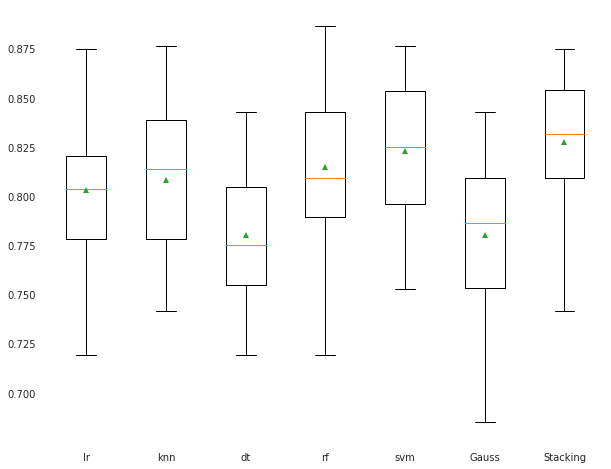

In [142]:
# plot model performance for comparison
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

**Observastion:**
 - Here we see that the mean and median accuracy of stacked model is quite higher than any other model

# Model Explaination

## Permutation Importance

Running Permutation Importance using Decision Tree

## ELI5

In [143]:
import eli5
from eli5.sklearn import PermutationImportance
stacking = get_stacking()
stacking_model = stacking.fit(X_train, y_train)
perm = PermutationImportance(stacking_model, random_state=101).fit(X_test, y_test)      # Evaluate the permutation importance 
eli5.show_weights(perm, feature_names = X_test.columns.values)                    # Display the weights of each features


Using TensorFlow backend.


**Conclusion**: The columns in the green are the most important features.

## SHAP

Let's see how the columns impact a single record of data

In [144]:
dt_model= dt.fit(X_train, y_train)
# svm_model= svm.fit(X_train, y_train)

row_to_show = 74                # The row for which we want to check the SHAP explanations
data_to_predict = X_test.iloc[row_to_show]
#data_to_predict

data_to_preddict_array = data_to_predict.values.reshape(1,-1)
dt_model.predict_proba(data_to_preddict_array)    # Prediction probability on the row of the data

dt_model.predict(data_to_preddict_array)         # Predicted output

array([1])

In [145]:
y_test.iloc[row_to_show]

1

**Prediction is correct**

In [146]:
import shap

# Object that can calculate Shap values
explainer = shap.TreeExplainer(dt_model)        # SHAP Tree Explainer

# Calculate the shap values
shap_values = explainer.shap_values(data_to_predict)      # SHAP explanations

In [147]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_to_predict)

## LIME

In [148]:
import lime
import lime.lime_tabular



explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns.values.tolist(),
                                                   mode='regression', class_names='loan_status_cat')

In [149]:
lime_exp=explainer.explain_instance(X_test.iloc[10], dt.predict_proba, num_features=X_test.shape[1], top_labels = 1)
lime_exp.show_in_notebook(show_table=True, show_all=False)

In [226]:
test.shape

(416, 13)